In [1]:
import pandas as pd
import numpy as np
from numpy import NaN
import re
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import shapely
import json

# Part 1 - Data Gathering

1. Make use of the API to find all aggravated burglary incidents () that were reported during the nine month period from January 1, 2022 through September 30, 2021. https://data.nashville.gov/Police/Metro-Nashville-Police-Department-Incidents/2u6v-ujjs

In [2]:
#Burglary data API 
offense_type = "offense_description=BURGLARY- AGGRAVATED"
date_range = "$where=incident_reported between '2022-01-01T00:00:00' and '2022-09-30T23:59:59'"
endpoint = f'https://data.nashville.gov/resource/2u6v-ujjs.json?{offense_type}&{date_range}&$limit=25000'
response_1 = requests.get(endpoint)

In [3]:
api_data_burglaries = response_1.json()
agg_burglary_data_df = pd.DataFrame(api_data_burglaries)

2. Using the 2020 American Community Survey API, https://www.census.gov/data/developers/data-sets/acs-5year.html , obtain, for each census tract, the population (B01001_001E in the detailed tables) and the median income (S1901_C01_012E in the subject tables). Hint: Tennessee's FIPS code is 47 and Davidson County's FIPS code is 37.

In [4]:
with open('data/api_key.json') as fi: #Keeping US Census api key hidden in .json file, Extracting here
    credentials = json.load(fi)
api_key_census = credentials['api_key']

In [5]:
# Function that sends data to dataframe from census API, reformats the first row to column names
def json_to_df(response):
    return pd.DataFrame(response.json()[1:], columns=response.json()[0])

In [6]:
#This first url gathers the population data for each census tract
url_census_pop = 'https://api.census.gov/data/2020/acs/acs5/subject?get=NAME,S0101_C01_001E&for=tract:*&in=state:47&in=county:037&key={0}'.format(api_key_census)
response_2 = requests.get(url_census_pop)
census_tracts_pop = json_to_df(response_2)
census_tracts_pop.columns = ['Name', 'Population', 'state', 'county', 'tract']

In [7]:
#The second url gathers the median income data
url_census_med_income = 'https://api.census.gov/data/2020/acs/acs5/subject?get=NAME,S1901_C01_012E&for=tract:*&in=state:47&in=county:037&key={0}'.format(api_key_census)
response_3 = requests.get(url_census_med_income)
census_tracts_med_income = json_to_df(response_3)
census_tracts_med_income.columns = ['Name', 'median_income', 'state', 'county', 'tract']

In [8]:
#Merge the 2 DF's to combine the census information, change the pop and med_income to int32, filter out <= 0 med_income
census_tracts = pd.merge(census_tracts_pop, census_tracts_med_income, how='inner')

census_tracts[['median_income','Population']] = census_tracts[['median_income','Population']].astype('int32')
census_tracts = census_tracts[census_tracts['median_income'] > 0]

# Part 2 - Spatial Joining and Data Merging

3. Download the 2020 census tract shapefiles for Tennessee from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2020.html. (The FIPS code for Tennessee is 47). Perform a spatial join to determine the census tract in which each burglary incident occurred.

In [9]:
census_tract_shapes = gpd.read_file('data/tl_2020_47_tract/tl_2020_47_tract.shp')

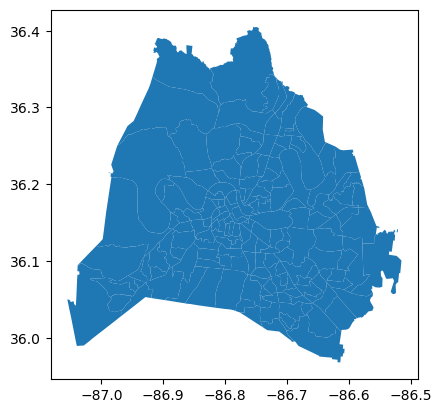

In [10]:
# Davidson County's FIPS code is 037
census_tract_shapes[census_tract_shapes['COUNTYFP']=='037'].plot()
plt.show()

In [11]:
davidson_county = census_tract_shapes[census_tract_shapes['COUNTYFP']=='037']

In [12]:
#Drop duplicate incidents of the same number, could be multiple victims for one burglary
agg_burglary_data_df = agg_burglary_data_df.drop_duplicates(subset=['incident_number'], keep='first')
# Add a point geometry column for the burglary data 
agg_burglary_data_df['geometry'] = gpd.points_from_xy(agg_burglary_data_df['longitude'], agg_burglary_data_df['latitude'])

In [13]:
# Create new geodatafram from burglary data using the same CRS as the davidson county shapes 
burglary_geo = gpd.GeoDataFrame(agg_burglary_data_df, 
                           crs = davidson_county.crs, 
                           geometry = agg_burglary_data_df['geometry'])

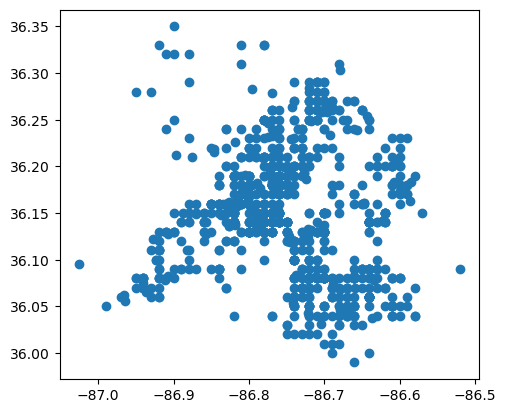

In [15]:
burglary_geo.plot()
plt.show()

In [16]:
burgs_by_tract = gpd.sjoin(burglary_geo, davidson_county, predicate='within',how='right')

4. Aggregate the data by census tract. Warning: each incident can appear multiple times if there are multiple victims, so be sure that you aren't double-counting any incidents. Which census tract had the highest number of burglaries? Which census tract had the highest number of burglaries per 1000 residents? Note: Make sure that you keep all census tracts, not just those that have had a burglary.

In [17]:
print('These are the number of aggravated burglaries within in each of the census tracts in Davidson Co. \n Census tract 163 had the most:')
burgs_by_tract['NAME'].value_counts()

These are the number of aggravated burglaries within in each of the census tracts in Davidson Co. 
 Census tract 163 had the most:


163       31
160       29
143       23
142       22
113       19
          ..
178        1
177.02     1
183.02     1
101.03     1
177.01     1
Name: NAME, Length: 174, dtype: int64

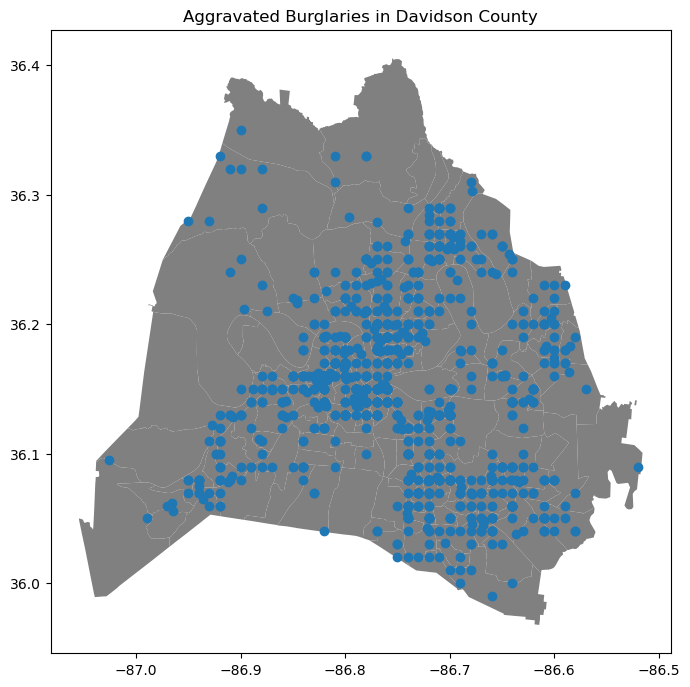

In [20]:
ax = davidson_county.plot(figsize = (8, 10), color = 'gray')
burglary_geo.plot(ax = ax)
ax.set_title('Aggravated Burglaries in Davidson County');

5. Merge census data 

In [21]:
burgs_by_tract.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1055 entries, 10 to 1693
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   index_left                   1044 non-null   float64 
 1   primary_key                  1044 non-null   object  
 2   incident_number              1044 non-null   object  
 3   report_type                  1044 non-null   object  
 4   report_type_description      1033 non-null   object  
 5   incident_status_code         1044 non-null   object  
 6   incident_status_description  1044 non-null   object  
 7   investigation_status         1044 non-null   object  
 8   incident_occurred            1044 non-null   object  
 9   incident_reported            1044 non-null   object  
 10  incident_location            1035 non-null   object  
 11  latitude                     1044 non-null   object  
 12  longitude                    1044 non-null   object  

In [26]:
census_tracts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170 entries, 0 to 173
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Name           170 non-null    object
 1   Population     170 non-null    int32 
 2   state          170 non-null    object
 3   county         170 non-null    object
 4   TRACTCE        170 non-null    int32 
 5   median_income  170 non-null    int32 
dtypes: int32(3), object(3)
memory usage: 7.3+ KB


In [25]:
#Adjust data types and column names to get ready for merge
burgs_by_tract['TRACTCE'] = burgs_by_tract['TRACTCE'].astype(int)
census_tracts['TRACTCE'] = census_tracts['TRACTCE'].astype(int)

census_tracts = census_tracts.rename(columns={'tract':'TRACTCE'})

In [27]:
tracts_merged = pd.merge(burgs_by_tract, census_tracts, how='inner')
#Cleanup columns so we dont have unnecessary data
final_df_1 = tracts_merged[['incident_reported','geometry','TRACTCE','NAMELSAD', 'COUNTYFP', 'Population', 'median_income']]

In [28]:
final_df_1.head()

,incident_reported,geometry,TRACTCE,NAMELSAD,COUNTYFP,Population,median_income
0,2022-04-15T19:03:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001
1,2022-09-18T12:12:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001
2,2022-06-18T16:50:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001
3,2022-07-10T10:46:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001
4,2022-03-28T19:56:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001


In [29]:
#Get the number of burglaries for each census tract area
fill=final_df_1['TRACTCE'].value_counts()
fill=fill.reset_index().rename(columns={'index': 'TRACTCE', 'TRACTCE': 'total_num_burgs_in_tract'})
fill.head()

,TRACTCE,total_num_burgs_in_tract
0,16300,31
1,16000,29
2,14300,23
3,14200,22
4,11300,19


In [30]:
#Now add the total num burgs for each census tract area with another merge
final_df_2 = pd.merge(final_df_1,fill,how='inner')
final_df_2.head()

,incident_reported,geometry,TRACTCE,NAMELSAD,COUNTYFP,Population,median_income,total_num_burgs_in_tract
0,2022-04-15T19:03:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001,18
1,2022-09-18T12:12:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001,18
2,2022-06-18T16:50:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001,18
3,2022-07-10T10:46:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001,18
4,2022-03-28T19:56:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001,18


In [31]:
#Now add column to calculate the burgs per 1000 residents
pop = final_df_2['Population']
tot_burgs_tract = final_df_2['total_num_burgs_in_tract']

final_df_2['burgs_per_1000'] = tot_burgs_tract/pop*1000

top_burgs_per_1000 = final_df_2[final_df_2['burgs_per_1000'] == final_df_2['burgs_per_1000'].max()]

print('The census tract with the highest number of burglaries per 1000 residents is', top_burgs_per_1000['NAMELSAD'].unique()[0], 'with', final_df_2['burgs_per_1000'].max(), 'burglaries per 1000 people.')

The census tract with the highest number of burglaries per 1000 residents is Census Tract 143 with 14.22387136672851 burglaries per 1000 people.


# Part 3 - Statistical Modeling

6. Explain the number of agg. burglaries using the median income of each census tract

In [32]:
final_df_2.head()

,incident_reported,geometry,TRACTCE,NAMELSAD,COUNTYFP,Population,median_income,total_num_burgs_in_tract,burgs_per_1000
0,2022-04-15T19:03:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001,18,4.026846
1,2022-09-18T12:12:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001,18,4.026846
2,2022-06-18T16:50:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001,18,4.026846
3,2022-07-10T10:46:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001,18,4.026846
4,2022-03-28T19:56:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001,18,4.026846


In [33]:
median_income_pivot = (
            final_df_2
            .pivot_table(
                index = 'TRACTCE',
                values = ['median_income','Population','total_num_burgs_in_tract','burgs_per_1000']
            )
)
median_income_pivot.head()

,Population,burgs_per_1000,median_income,total_num_burgs_in_tract
TRACTCE,,,,
10103,2411,0.414766,60000,1
10104,3002,2.331779,84831,7
10105,4839,1.033271,61115,5
10106,2948,2.713704,66940,8
10201,4283,1.167406,69185,5


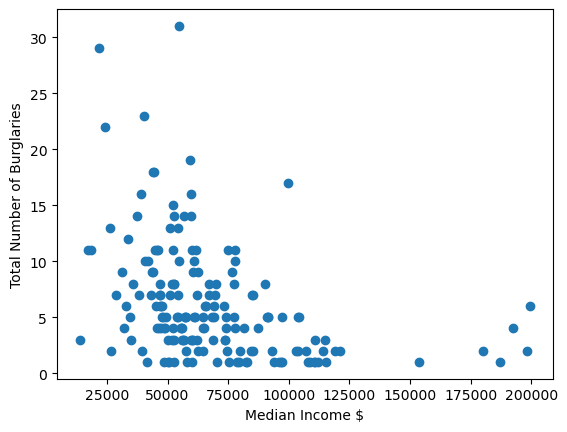

In [34]:
#Histogram with num burgs vs. median income
plt.scatter(median_income_pivot['median_income'], median_income_pivot['total_num_burgs_in_tract'])
plt.xlabel('Median Income $')
plt.ylabel('Total Number of Burglaries')
plt.show()

7. Poisson Regression for rate of burglaries per census tract, predictor being the median income. 

In [35]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import poisson
from ipywidgets import interact, FloatSlider, IntSlider

In [36]:
p_fit = smf.glm('burgs_per_1000 ~ median_income',
                 data = median_income_pivot,
                 family = sm.families.Poisson()
                 ).fit()

p_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         burgs_per_1000   No. Observations:                  170
Model:                            GLM   Df Residuals:                      168
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -285.13
Date:                Tue, 24 Jan 2023   Deviance:                       200.31
Time:                        09:27:16   Pearson chi2:                     291.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2743
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.6255      0.157     10.383      0.000       1.319       1.932
median_income -1.724e-05    2.6e-06     -6.634      0.000   -2.23e-05   -1.21e-05
=================================================================================
"""

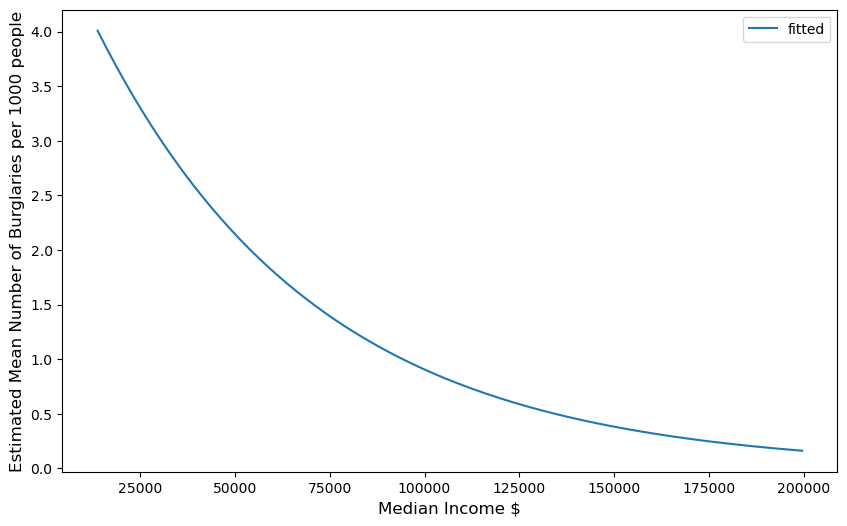

In [37]:
fit_df = pd.DataFrame({
    'median_income': np.linspace(start = median_income_pivot['median_income'].min(),
                       stop = median_income_pivot['median_income'].max(),
                       num = 150)
})
fit_df['fitted'] = p_fit.predict(fit_df)

fit_df.plot(x = 'median_income', y = 'fitted', figsize = (10,6))

fontsize = 12
plt.xlabel('Median Income $', fontsize = fontsize)
plt.ylabel('Estimated Mean Number of Burglaries per 1000 people', fontsize = fontsize);

In [38]:
@interact(median_income = IntSlider(value = 40, min = median_income_pivot['median_income'].min(), max = median_income_pivot['median_income'].max()))
def fit_plot(median_income):
    
    mu = np.exp(p_fit.params['Intercept'] + median_income * p_fit.params['median_income'])
    x = np.arange(start = 0, stop = 10, step = 1)
    y = poisson.pmf(x, mu = mu)

    plt.figure(figsize = (10,5))
    plt.bar(x, y, edgecolor = 'black')
    plt.xticks(x)
    plt.xlabel('Number of Occurrences')
    plt.ylabel('Probability')
    plt.title(f'Estimated Distribution of Number of Burglaries\nmedian_income = {median_income}\n$\mu$={round(mu, 3)}');

interactive(children=(IntSlider(value=13750, description='median_income', max=199643, min=13750), Output()), _…

Log Offset to account for different Population Sizes

In [39]:
p_fit_2 = smf.glm('burgs_per_1000 ~ median_income',
                 data = median_income_pivot,
                 offset = np.log(median_income_pivot['Population']),
                 family = sm.families.Poisson()
                 ).fit()

p_fit_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         burgs_per_1000   No. Observations:                  170
Model:                            GLM   Df Residuals:                      168
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -345.70
Date:                Tue, 24 Jan 2023   Deviance:                       321.46
Time:                        09:27:55   Pearson chi2:                     666.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3279
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -6.4739      0.166    -38.948      0.000      -6.800      -6.148
median_income -2.058e-05   2.78e-06     -7.393      0.000    -2.6e-05   -1.51e-05
=================================================================================
"""

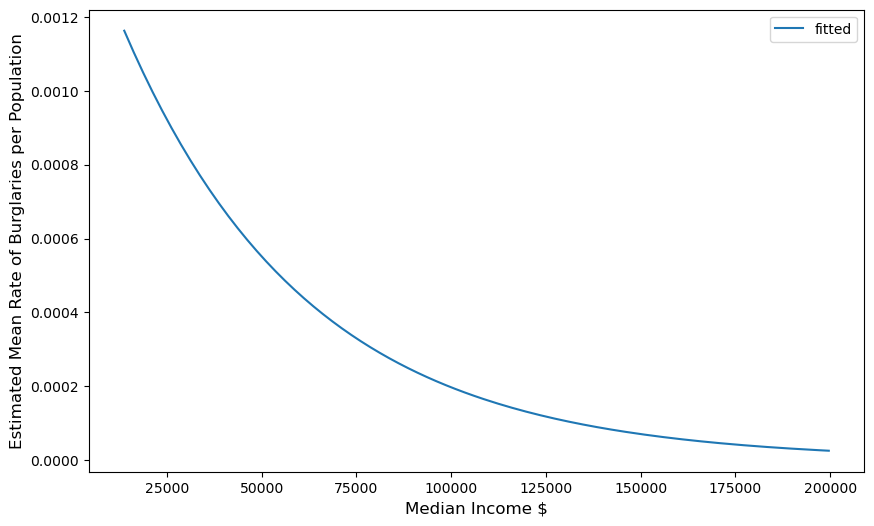

In [40]:
fit_df_2 = pd.DataFrame({
    'median_income': np.linspace(start = median_income_pivot['median_income'].min(),
                       stop = median_income_pivot['median_income'].max(),
                       num = 150)
})
fit_df_2['fitted'] = p_fit_2.predict(fit_df)

fit_df_2.plot(x = 'median_income', y = 'fitted', figsize = (10,6))

fontsize = 12
plt.xlabel('Median Income $', fontsize = fontsize)
plt.ylabel('Estimated Mean Rate of Burglaries per Population', fontsize = fontsize);